In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate(); Pkg.precompile()
using TOML 
include(joinpath(@__DIR__, "..", "src", "utils.jl"))

input_file = joinpath(@__DIR__, "..", "main", "input_values.toml")
input_parameters = load_parameters(input_file)

println("=== Input Parameters === \n") 
pretty_print_table(input_parameters)  
println("\n")

  Activating project at `~/Desktop/ETH/HeliosphereTrajectories`


=== Input Parameters === 

particle_size = 50                                            n_grid = 20                                                 
distance_TS = 1.1967829656e13                                 charging_type = continuous                                  
plasma_model = turning_turning                                q_over_m_value = 16.0                                       
beta_angle = 0.0                                              B_mag_ISM = 6.0e-10                                         
mode = full                                                   distance_Approach = 2.2439680605e12                         
dt = 7000.0                                                   particle_type = silicate                                    
alpha_angle = 180.0                                           plane = both                                                
plot_color = speed                                            plot_vectors = true                               

In [2]:
using DataFrames, StaticArrays

include(joinpath(@__DIR__, "..", "src", "trajectory.jl"))
include(joinpath(@__DIR__, "..", "src", "constants.jl"))

charging_data = load(joinpath(@__DIR__, "..", "data", "charging_dict.jld2"))
charging_dict = charging_data["charging_dict"] 

plasma_list = ["straight_straight", "turning_turning"]
mag_list    = ["simple", "solar_min", "solar_max", "Parker"]
charge_list = ["constant", "instant"]

distances = collect(10.0:10.0:170.0)

# times = [solar min, solar max, intermediate] for parker spiral

EOMMap = Dict(
    "constant"  => EqMotionConstant!,
    "instant"   => EqMotionInstant!,
    "continuous"=> EqMotionContinuous!
)

direction = normalize(SVector{3,Float64}(10.0, 1.0, 1.0))

vel = 26e+3 # m/s

particle_type = input_parameters["particle_type"]
particle_size = input_parameters["particle_size"]
time = input_parameters["min_time"]
beta_val = input_parameters["beta_value"]
density = particle_type == "carbonaceous" ? 2.5 : 3.3

results = DataFrame(
    plasma_model = String[],
    mag_model    = String[],
    charge_model = String[],
    dist_AU      = Float64[],
    time         = Float64[],
    ax           = Float64[],
    ay           = Float64[],
    az           = Float64[],
    amag         = Float64[],
)

u = nothing

for plasma_model in plasma_list
    for mag_model in mag_list
        for charge_model in charge_list
            EOM! = EOMMap[charge_model]
            for dist in distances
                # for time in times
                    r = dist * AU
                    u = SVector{6, Float64}(
                        r * direction[1], r * direction[2], r * direction[3], 
                        -vel * direction[1], -vel * direction[2], -vel * direction[3]
                    )
                    du = similar(u)

                    input_parameters["plasma_model"]  = plasma_model
                    input_parameters["B_model"]       = mag_model
                    input_parameters["charging_type"] = charge_model
                    
                    if charge_model == "constant"
                        qm_constant = input_parameters["q_over_m_value"]
                        params = (beta_val, qm_constant)
                    elseif charge_model == "instant"
                        region = (r ≤ input_parameters["distance_TS"]) ? "TerminationShock" : (r ≤ input_parameters["distance_HP"]) ? "Heliosheath" : "VLISM" 
                        v_eq = voltage_at_size(charging_dict, particle_type, region, particle_size)  
                        qm_new = calculate_qm(v_eq, particle_size, density)
                        params = (beta_val, qm_new)
                    end

                    EOM!(du, u, params, time, input_parameters)

                    a = SVector{3,Float64}(du[4], du[5], du[6])
                    push!(results, (plasma_model, mag_model, charge_model, dist, time, a[1], a[2], a[3], norm(a)))
                # end
            end
        end
    end
end

## Table 1

In [3]:
cols = [:ax, :ay, :az, :amag]

base1 = subset(results,
    :plasma_model => ByRow(==("turning_turning")),
    :mag_model    => ByRow(x -> x in ("solar_min", "solar_max")),
    :charge_model => ByRow(x -> x in ("constant", "instant"))
)

df_const = subset(base1, :charge_model => ByRow(==("constant")))
df_const = select(df_const, :mag_model, :dist_AU, cols...)
rename!(df_const, Dict(c => Symbol("const_", c) for c in cols))

df_inst = subset(base1, :charge_model => ByRow(==("instant")))
df_inst = select(df_inst, :mag_model, :dist_AU, cols...)
rename!(df_inst, Dict(c => Symbol("inst_", c) for c in cols))

table1 = innerjoin(df_const, df_inst, on=[:mag_model, :dist_AU])
sort!(table1, [:mag_model, :dist_AU])

34×10 DataFrame
 Row │ mag_model  dist_AU  const_ax     const_ay     const_az      const_amag  ⋯
     │ String     Float64  Float64      Float64      Float64       Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ solar_max     10.0  -0.00010073  -1.0073e-5    0.00101738   0.0010224   ⋯
   2 │ solar_max     20.0   0.00010073   1.0073e-5   -0.00101738   0.0010224
   3 │ solar_max     30.0  -0.00010073  -1.0073e-5    0.00101738   0.0010224
   4 │ solar_max     40.0   0.00010073   1.0073e-5   -0.00101738   0.0010224
   5 │ solar_max     50.0   0.00010073   1.0073e-5   -0.00101738   0.0010224   ⋯
   6 │ solar_max     60.0  -0.00010073  -1.0073e-5    0.00101738   0.0010224
   7 │ solar_max     70.0   0.00010073   1.0073e-5   -0.00101738   0.0010224
   8 │ solar_max     80.0  -2.97935e-5  -2.97935e-6   0.000300914  0.0003024
  ⋮  │     ⋮         ⋮          ⋮            ⋮            ⋮            ⋮       ⋱
  28 │ solar_min    110.0   2.47141e-5  -0.0          2.45917e-6   2.48361e-5  ⋯
  29 │ solar_min    120.0   2.47141e-5  -0.0          2.45917e-6   2.48361e-5
  30 │ solar_min    130.0   2.47141e-5  -0.0          2.45917e-6   2.48361e-5
  31 │ solar_min    140.0   2.47141e-5  -0.0          2.45917e-6   2.48361e-5
  32 │ solar_min    150.0   2.47141e-5  -0.0          2.45917e-6   2.48361e-5  ⋯
  33 │ solar_min    160.0   2.47141e-5  -0.0          2.45917e-6   2.48361e-5
  34 │ solar_min    170.0   2.47141e-5  -0.0          2.45917e-6   2.48361e-5
                                                   4 columns and 19 rows omitted

## Table 2

In [4]:
cols = [:ax, :ay, :az, :amag]

base2 = subset(results,
    :charge_model => ByRow(==("instant")),
    :mag_model    => ByRow(x -> x in ("solar_min", "solar_max")),
    :plasma_model => ByRow(x -> x in ("straight_straight", "turning_turning"))
)

df_rad = subset(base2, :plasma_model => ByRow(==("straight_straight")))
df_rad = select(df_rad, :mag_model, :dist_AU, cols...)
rename!(df_rad, Dict(c => Symbol("rad_", c) for c in cols))

df_turn = subset(base2, :plasma_model => ByRow(==("turning_turning")))
df_turn = select(df_turn, :mag_model, :dist_AU, cols...)
rename!(df_turn, Dict(c => Symbol("turn_", c) for c in cols))

table2 = innerjoin(df_rad, df_turn, on=[:mag_model, :dist_AU])
sort!(table2, [:mag_model, :dist_AU])

34×10 DataFrame
 Row │ mag_model  dist_AU  rad_ax        rad_ay       rad_az       rad_amag    ⋯
     │ String     Float64  Float64       Float64      Float64      Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ solar_max     10.0  -0.000370132  -3.70132e-5   0.00373834  0.0037568   ⋯
   2 │ solar_max     20.0   0.000370132   3.70132e-5  -0.00373834  0.0037568
   3 │ solar_max     30.0  -0.000370132  -3.70132e-5   0.00373834  0.0037568
   4 │ solar_max     40.0   0.000370132   3.70132e-5  -0.00373834  0.0037568
   5 │ solar_max     50.0   0.000370132   3.70132e-5  -0.00373834  0.0037568   ⋯
   6 │ solar_max     60.0  -0.000370132  -3.70132e-5   0.00373834  0.0037568
   7 │ solar_max     70.0   0.000370132   3.70132e-5  -0.00373834  0.0037568
   8 │ solar_max     80.0  -0.000109476  -1.09476e-5   0.0011057   0.00111117
  ⋮  │     ⋮         ⋮          ⋮             ⋮            ⋮           ⋮       ⋱
  28 │ solar_min    110.0   5.22192e-6   -0.0          5.19606e-7  5.2477e-6   ⋯
  29 │ solar_min    120.0   5.22192e-6   -0.0          5.19606e-7  5.2477e-6
  30 │ solar_min    130.0   5.22192e-6   -0.0          5.19606e-7  5.2477e-6
  31 │ solar_min    140.0   5.22192e-6   -0.0          5.19606e-7  5.2477e-6
  32 │ solar_min    150.0   5.22192e-6   -0.0          5.19606e-7  5.2477e-6   ⋯
  33 │ solar_min    160.0   5.22192e-6   -0.0          5.19606e-7  5.2477e-6
  34 │ solar_min    170.0   5.22192e-6   -0.0          5.19606e-7  5.2477e-6
                                                   4 columns and 19 rows omitted

## Model Dependency

In [23]:
include(joinpath(@__DIR__, "..", "src", "plotting.jl"))

function PlotTrajectory(sol, input; label="Trajectory")
    sol_time = sol.t ./ yr
    sol_x = [u[1] for u in sol.u] ./ AU
    sol_y = [u[2] for u in sol.u] ./ AU
    sol_z = [u[3] for u in sol.u] ./ AU
    plane = "xz" #input["plane"] 
    # trajectory_duration = (sol_time[end] - sol_time[1])  # in years 
    sol_speed = [norm(u[4:6]) for u in sol.u] ./ 1e3   # in km/s   
    npts = length(sol_time)
    if npts > 1000
        idx = round.(Int, range(1, npts, length=1000))
        sol_time = sol_time[idx]
        sol_x, sol_y, sol_z, sol_speed = sol_x[idx], sol_y[idx], sol_z[idx], sol_speed[idx]
    end     

    xdata = sol_x 
    ydata = plane == "xz" ? sol_z : sol_y 

    # xleft, xright = ( minimum( [70, minimum(xdata)-9] ), minimum( [130, maximum(xdata)+9] ) )
    # ybottom, ytop = ( minimum(ydata)-12, maximum(ydata)+12 )

    # Plots.plot(xdata, ydata, linez=sol_speed, color=:plasma, linewidth=1.5, label=label) 
    plt = Plots.plot(
        xdata, ydata, linewidth=1.5, label=label,
        xlabel="x [AU]", ylabel="z [AU]",
        aspect_ratio = :equal,
        # xlims = (xleft, xright),  ylims = (ybottom, ytop),
        xlims = (0, 120),  ylims = (-30, 30),
        size = (900, 600), legend=:outerbottom, grid=true,
        gridlinewidth = 2, margin = 4Plots.mm, alpha = 0.95,
    ) 
    Plots.scatter!(plt, [xdata[end]], [ydata[end]], color=:black, markersize=5, label="")
    BoundaryLines!(plt, input; boundary_scale=0.95)

    # Sun
    scatter!(plt, [0], [0], color=:gold, markerstrokecolor=:black, markersize=8, label="")
    
    return plt 
end

function AddTrajectory!(plt, sol, input; label="Trajectory")
    sol_time = sol.t ./ yr
    sol_x = [u[1] for u in sol.u] ./ AU
    sol_y = [u[2] for u in sol.u] ./ AU
    sol_z = [u[3] for u in sol.u] ./ AU
    plane = "xz" #input["plane"] 
    # trajectory_duration = (sol_time[end] - sol_time[1])  # in years 
    sol_speed = [norm(u[4:6]) for u in sol.u] ./ 1e3   # in km/s   
    npts = length(sol_time)
    if npts > 1000
        idx = round.(Int, range(1, npts, length=1000))
        sol_time = sol_time[idx]
        sol_x, sol_y, sol_z, sol_speed = sol_x[idx], sol_y[idx], sol_z[idx], sol_speed[idx]
    end     

    xdata = sol_x 
    ydata = plane == "xz" ? sol_z : sol_y 

    # xleft, xright = ( minimum( [70, minimum(xdata)-9] ), minimum( [130, maximum(xdata)+9] ) )
    # ybottom, ytop = ( minimum(ydata)-12, maximum(ydata)+12 )

    # Plots.plot!(plt, xdata, ydata, linez=sol_speed, color=:plasma, linewidth=1.5, label=label) 
    Plots.plot!(plt, xdata, ydata, linewidth=1.5, label=label)  # , xlims = (xleft, xright),  ylims = (ybottom, ytop)) 
    Plots.scatter!(plt, [xdata[end]], [ydata[end]], color=:black, markersize=5, label="")
end


AddTrajectory! (generic function with 1 method)

--- Solution Characteristics ---
Integration time: 0.0 → 14.0 years
Solution size: (7, 51829)
--- Solution Characteristics ---
Integration time: 0.0 → 14.0 years
Solution size: (7, 66047)
Affect triggered at 100.0 AU. New Q/m of 39.828
Affect triggered at 80.0 AU. New Q/m of 58.792
--- Solution Characteristics ---
Integration time: 0.0 → 14.0 years
Solution size: (6, 46465)
--- Solution Characteristics ---
Integration time: 0.0 → 14.0 years
Solution size: (6, 29093)
--- Solution Characteristics ---
Integration time: 0.0 → 14.0 years
Solution size: (6, 31037)
--- Solution Characteristics ---
Integration time: 0.0 → 14.0 years
Solution size: (6, 30912)


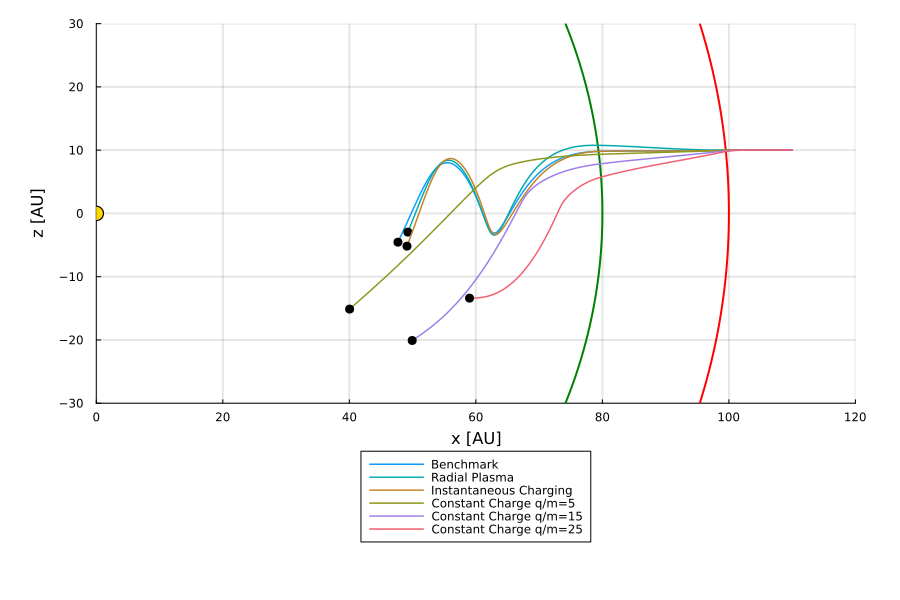

In [42]:
include(joinpath(@__DIR__, "..", "src", "trajectory.jl"))

# Benchmark solution
input_parameters["plasma_model"]  = "turning_turning"
input_parameters["B_model"]       = "Parker"
input_parameters["charging_type"] = "continuous"

# input_parameters["B_field_time_offset"] = 0.0   # solar minimum
# input_parameters["B_field_time_offset"] = 5.5*yr   # solar maximum
input_parameters["B_field_time_offset"] = 2.75*yr  # intermediate

input_parameters["max_time"] = 14.0*yr

sol_b, q_hist_b = ComputeTrajectory(input_parameters)

# Radial plasma
input_p = deepcopy(input_parameters)
input_p["plasma_model"] = "straight_straight"
sol_p, q_hist_p = ComputeTrajectory(input_p)

# Instantaneous charging
input_i = deepcopy(input_parameters)
input_i["charging_type"] = "instant"
sol_i, q_hist_i = ComputeTrajectory(input_i)

# Constant charging q/m=5
input_c5 = deepcopy(input_parameters)
input_c5["charging_type"] = "constant"
input_c5["q_over_m_value"] = 5.0
sol_c5, q_hist_c5 = ComputeTrajectory(input_c5)

# Constant charging q/m=15
input_c15 = deepcopy(input_parameters)
input_c15["charging_type"] = "constant"
input_c15["q_over_m_value"] = 15.0
sol_c15, q_hist_c15 = ComputeTrajectory(input_c15)

# Constant charging q/m=25
input_c25 = deepcopy(input_parameters)
input_c25["charging_type"] = "constant"
input_c25["q_over_m_value"] = 25.0
sol_c25, q_hist_c25 = ComputeTrajectory(input_c25)

plt = PlotTrajectory(sol_b, input_parameters; label="Benchmark")
AddTrajectory!(plt, sol_p, input_p; label="Radial Plasma")
AddTrajectory!(plt, sol_i, input_i; label="Instantaneous Charging")
AddTrajectory!(plt, sol_c5, input_c5; label="Constant Charge q/m=5")
AddTrajectory!(plt, sol_c15, input_c15; label="Constant Charge q/m=15")
AddTrajectory!(plt, sol_c25, input_c25; label="Constant Charge q/m=25")

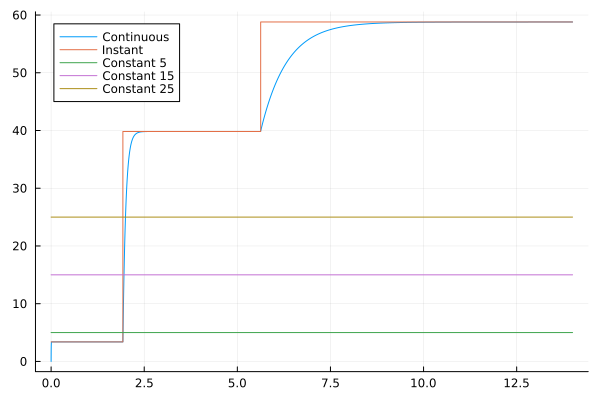

In [43]:
plt_ch = Plots.plot(sol_b.t./yr, q_hist_b; label="Continuous")
Plots.plot!(plt_ch, sol_i.t./yr, q_hist_i; label="Instant")
Plots.plot!(plt_ch, sol_c5.t./yr, q_hist_c5; label="Constant 5")
Plots.plot!(plt_ch, sol_c15.t./yr, q_hist_c15; label="Constant 15")
Plots.plot!(plt_ch, sol_c25.t./yr, q_hist_c25; label="Constant 25")

display(plt_ch)

### Errors

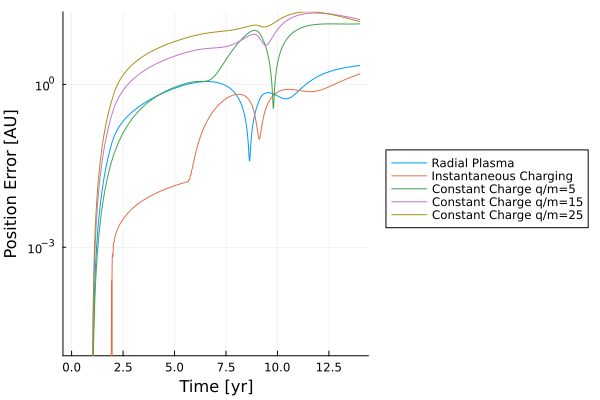

In [70]:
using LinearAlgebra

t_vec = sol_b.t
err_radial  = replace(norm.(eachcol(sol_p(t_vec)[1:3, 2:end] .- sol_b[1:3, 2:end]))./AU, 0.0 => NaN)
err_instant = replace(norm.(eachcol(sol_i(t_vec)[1:3, 2:end] .- sol_b[1:3, 2:end]))./AU, 0.0 => NaN)
err_const5  = replace(norm.(eachcol(sol_c5(t_vec)[1:3, 2:end] .- sol_b[1:3, 2:end]))./AU, 0.0 => NaN)
err_const15 = replace(norm.(eachcol(sol_c15(t_vec)[1:3, 2:end] .- sol_b[1:3, 2:end]))./AU, 0.0 => NaN)
err_const25 = replace(norm.(eachcol(sol_c25(t_vec)[1:3, 2:end] .- sol_b[1:3, 2:end]))./AU, 0.0 => NaN)


plt = Plots.plot(t_vec[2:end]./yr,  err_radial; label="Radial Plasma", xlabel="Time [yr]", ylabel="Position Error [AU]", yscale=:log10, ylim=(1e-5, Inf), legend=:outerright, grid=true)
Plots.plot!(plt, t_vec[2:end]./yr, err_instant; label="Instantaneous Charging")
Plots.plot!(plt, t_vec[2:end]./yr,  err_const5; label="Constant Charge q/m=5")
Plots.plot!(plt, t_vec[2:end]./yr, err_const15; label="Constant Charge q/m=15")
Plots.plot!(plt, t_vec[2:end]./yr, err_const25; label="Constant Charge q/m=25")